# Red Wine Quality Prediction 

Authors (Alphabetical by Last Name): Nicole Bidwell, Alysen Townsley, Ruocong Sun, Hongyang Zhang

## Summary 

In this project our group seeks to use machine learning algorithms to predict wine quality (scale of 0 to 10) using physiochemical properties of the liquid. We use a train-test split and cross-validation to simulate the model encountering unseen data. We use and tune the parameters of several classification models: logistic regression, decision tree, kNN, and SVM RBF to see which one has the highest accuracy, and then deploy the winner onto the test set. The final test set accuracy is around 62 percent. Depending on the standard, this can be decent or poor. However, a more important note is that for the really extreme quality ones (below 5 or above 6), the model was unable to identify quite a few of them correctly, suggesting that it is not very robust to outliers. We include a final discussion section on some of the potential causes for this performance as well as proposed solutions for any future analysis.

## Introduction 

Red wines have a long history that can be traced all the way back to the ancient Greeks. Today, they are more accessible to an average person than ever and the entire industry is estimated to be worth around 109.5 billion USD (The Business Research Company). Despite its ubiquity, most people can barely tell the difference between a good and a bad wine, to the point where we need trained professionals (sommeliers) to understand the difference. In this project, we seek to use machine learning algorithms to predict the quality of the wine based on the physiochemical properties of the liquid.  This model, if effective, could allow manufactures and suppliers to have a more robust understanding of the wine quality based on measurable properties.

## Methods & Results

In [1]:
import pandas as pd 
import numpy as np
import sys
from hashlib import sha1
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.dummy import DummyClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    cross_validate,
    train_test_split,
)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import altair as alt
from sklearn.linear_model import Ridge
from sklearn.metrics import ConfusionMatrixDisplay 

### EDA
#### Dataset Description
The dataset is the "winequality-red.csv" file from the <a href=https://archive.ics.uci.edu/dataset/186/wine+quality>UC Irvine Machine Learning Repository</a>, which was originally referenced from <a href=http://www3.dsi.uminho.pt/pcortez/wine/>Decision Support Systems, Elsevier</a>. The dataset contains physiochemical proprties (features) of red vinho verde wine samples from the north of Portugal, along with an associated wine quality score from 0 (worst) to 10 (best). 

In [2]:
# Import the dataset:
df = pd.read_csv('../data/winequality-red.csv', sep = ';')

# Visualize the first 5 rows:
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [3]:
# This section is to be deleted after the report is compiled.
# Determine the size of the dataset:
print(df.shape)

# Determine the value counts for each unique target (quality) value::
print(df.quality.unique())
df.quality.value_counts().sort_index()

(1599, 12)
[5 6 7 4 8 3]


quality
3     10
4     53
5    681
6    638
7    199
8     18
Name: count, dtype: int64

There are 11 feature columns representing physiochemical characteristics of the wines, such as fixed acidity, residual sugar, chlorides, density, etc. There are 1598 rows or observations in the dataset. The target is the quality column which is listed as a set of ordinal values from 3 to 8, although they could go as low as 0 or as high as 10 (This data set does not contain those observations). Most observations have an "average" quality of 5 or 6, with fewer below a score of 5 or above a score of 6.

In [4]:
# View feature dtypes and counts, null values:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


All 11 features are numeric with no missing values. The response variable is a label for wine quality ranging from 3 to 8. We will treat this as a classification problem for our models.

In [5]:
# View summary statistics:
df.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


#### Visualization

We first observe the distribution of the features using their statistical summaries and a histogram. We can see that the majority of features have a skewed distribution, with many containing outliers. Volatile acidity, residual sugar, chlorides, free sulfur dioxide, total sulfur dioxide, and sulphates all have very extreme outliers.

In [6]:
# Features 
feature_df = df.drop('quality', axis=1)

feature_names = list(feature_df.columns)

alt.Chart(feature_df).mark_bar().encode(
     alt.X(alt.repeat()).type('quantitative').bin(maxbins=40),
     y='count()',
).properties(
    width=400,
    height=300
).repeat(
    feature_names, 
    columns=3
)

alt.RepeatChart(...)

### Model Training
#### Model Selection and Hyperparameter Tuning

Our method for model selection involves using 5-fold cross-validation and hyperparameter tuning on several models: logistic regression, decision tree, kNN and SVM RBF. We use validation accuracy as our metric. Below we first use a dummy classifier to establish the baseline.

In [7]:
X = df.drop(columns = ['quality'])
y = df['quality']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 522)

In [8]:
#Baseline
baseline = DummyClassifier(random_state=522)
pd.DataFrame(cross_validate(baseline, X_train, y_train, return_train_score=True))

,fit_time,score_time,test_score,train_score
0,0.000995,0.0,0.441964,0.440223
1,0.000000,0.0,0.437500,0.441341
2,0.000000,0.0,0.437500,0.441341
3,0.000000,0.0,0.441964,0.440223
4,0.000000,0.0,0.443946,0.439732


In [9]:
np.mean(pd.DataFrame(cross_validate(baseline, X_train, y_train, return_train_score=True)), axis=0)

fit_time       0.000800
score_time     0.000200
test_score     0.440575
train_score    0.440572
dtype: float64

As we can see, the baseline obtains an accuracy of around 44 percent. We now use cross cross validation paired with hyperparameter tuning to identify a model that performs the best. 

In [10]:
pipe_lr = Pipeline([('scl', StandardScaler()),
                    ('LR', LogisticRegression(random_state=522))])
pipe_dt = Pipeline([('scl', StandardScaler()),
                    ('DT', DecisionTreeClassifier(random_state=522))])
pipe_knn = Pipeline([('scl', StandardScaler()),
                    ('KNN', KNeighborsClassifier())])
pipe_svm = Pipeline([('scl', StandardScaler()),
                     ('SVM', SVC(random_state=522))])

In [11]:
lr_param_grid = [{'LR__C': [0.001, 0.01, 0.1, 1.0, 10, 100, 1000],
                  'LR__class_weight': ['balanced', None]}]
dt_param_grid = [{'DT__criterion': ['gini', 'entropy'],
                  'DT__max_depth': 2 ** np.arange(8),
                  'DT__class_weight': ['balanced', None]}]
knn_param_grid = [{'KNN__n_neighbors': [1, 2, 3, 4, 5, 6]}]
svm_param_grid = [{'SVM__C': [0.001, 0.01, 0.1, 1.0, 10, 100, 1000],
                   'SVM__gamma': [0.001, 0.01, 0.1, 1.0, 10, 100, 1000],
                   'SVM__class_weight': ['balanced', None]}]

In [12]:
lr_grid_search = GridSearchCV(estimator=pipe_lr, param_grid=lr_param_grid, n_jobs=-1, return_train_score=True)

dt_grid_search = GridSearchCV(estimator=pipe_dt, param_grid=dt_param_grid, n_jobs=-1, return_train_score=True)

knn_grid_search = GridSearchCV(estimator=pipe_knn, param_grid=knn_param_grid, n_jobs=-1, return_train_score=True)

svm_grid_search = GridSearchCV(estimator=pipe_svm, param_grid=svm_param_grid, n_jobs=-1, return_train_score=True)

In [13]:
grids = [lr_grid_search, dt_grid_search, knn_grid_search, svm_grid_search]
for pipe in grids:
    pipe.fit(X_train, y_train)

In [14]:
lr_df = (pd.DataFrame(lr_grid_search.cv_results_)[
    [
        "mean_test_score",
        "mean_train_score",
        "param_LR__C",
        "param_LR__class_weight",
        "mean_fit_time",
        "rank_test_score",
    ]
].set_index("rank_test_score").sort_index())
lr_df.head(1)

,mean_test_score,mean_train_score,param_LR__C,param_LR__class_weight,mean_fit_time
rank_test_score,,,,,
1,0.586275,0.592495,0.1,None,0.034327


In [15]:
dt_df = (pd.DataFrame(dt_grid_search.cv_results_)[
    [
        "mean_test_score",
        "mean_train_score",
        "param_DT__criterion",
        "param_DT__max_depth",
        "param_DT__class_weight",
        "mean_fit_time",
        "rank_test_score",
    ]
].set_index("rank_test_score").sort_index())
dt_df.head(1)

,mean_test_score,mean_train_score,param_DT__criterion,param_DT__max_depth,param_DT__class_weight,mean_fit_time
rank_test_score,,,,,,
1,0.59335,0.993743,gini,16,None,0.016144


In [16]:
knn_df = (pd.DataFrame(knn_grid_search.cv_results_)[
    [
        "mean_test_score",
        "mean_train_score",
        "param_KNN__n_neighbors",
        "mean_fit_time",
        "rank_test_score",
    ]
].set_index("rank_test_score").sort_index())
knn_df.head(1)

,mean_test_score,mean_train_score,param_KNN__n_neighbors,mean_fit_time
rank_test_score,,,,
1,0.59781,1.0,1,0.002311


In [17]:
svm_df = (pd.DataFrame(svm_grid_search.cv_results_)[
    [
        "mean_test_score",
        "mean_train_score",
        "param_SVM__C",
        "param_SVM__gamma",
        "param_SVM__class_weight",
        "mean_fit_time",
        "rank_test_score",
    ]
].set_index("rank_test_score").sort_index())
svm_df.head(1)

,mean_test_score,mean_train_score,param_SVM__C,param_SVM__gamma,param_SVM__class_weight,mean_fit_time
rank_test_score,,,,,,
1,0.613053,0.76787,1000,0.01,None,0.222646


We see that logistic regression has a best validation score of 59 percent; decision tree is 59 percent; kNN is 60 percent, and RBF SVM is 61 percent. As a result, we will use the tuned RBF SVM as our model on the test set.

#### Test Set Deployment

In [18]:
best_pipe = make_pipeline(StandardScaler(), SVC(C=1000, gamma=0.01, class_weight=None))
best_pipe.fit(X_train, y_train)
best_pipe.score(X_test, y_test)

0.6229166666666667

There is a slight improvement in accuracy with the test set. We want to further probe into its performance by looking at the confusion matrix.

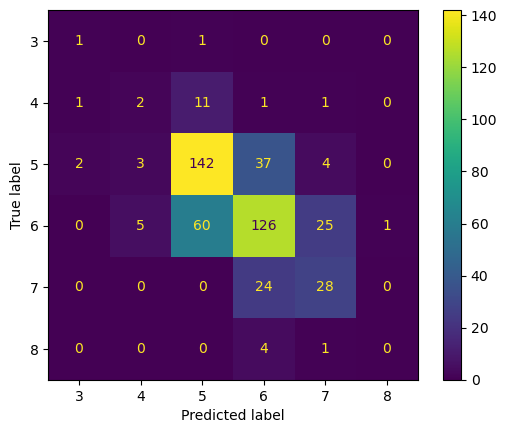

In [19]:
ConfusionMatrixDisplay.from_estimator(
    best_pipe,
    X_test,
    y_test,
    values_format="d",  # Show the full number 59,700 instead of 6e+04,
    # normalize='all'  # Show the proportion in each square instead of the count
)

For the really mediocre wines (5 and 6), the model can predict most of them correctly, but the model fails to predict a large proportion of extreme ones correctly, suggesting that the model is not too robust against outliers.

## Discussion 

In this project, we built several machine learning classification models seeking to predict the wine quality based on the physiochemical properties of the liquid. By trying out different models with different hyperparameters, we have found the for our data set, the best performing model is RBF SVM. However, despite being the best, the accuracy is only around 62 percent. Depending on the situation this can be poor or decent. More importantly, the algorithm seems to not be able to identify the outliers precisely, and in the case where people want to be able to find really good or bad wines, this model's performance would not be able to meet people's expectations. Our group's discussion has concluded that there might be several factors leading to this phenomenon:

### High correlations:

In [20]:
# Features 
feature_df = df.drop('quality', axis=1)

feature_names = list(feature_df.columns)

feature_df.corr(numeric_only=True).style.background_gradient('PiYG')

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
fixed acidity,1.000000,-0.256131,0.671703,0.114777,0.093705,-0.153794,-0.113181,0.668047,-0.682978,0.183006,-0.061668
volatile acidity,-0.256131,1.000000,-0.552496,0.001918,0.061298,-0.010504,0.076470,0.022026,0.234937,-0.260987,-0.202288
citric acid,0.671703,-0.552496,1.000000,0.143577,0.203823,-0.060978,0.035533,0.364947,-0.541904,0.312770,0.109903
residual sugar,0.114777,0.001918,0.143577,1.000000,0.055610,0.187049,0.203028,0.355283,-0.085652,0.005527,0.042075
chlorides,0.093705,0.061298,0.203823,0.055610,1.000000,0.005562,0.047400,0.200632,-0.265026,0.371260,-0.221141
free sulfur dioxide,-0.153794,-0.010504,-0.060978,0.187049,0.005562,1.000000,0.667666,-0.021946,0.070377,0.051658,-0.069408
total sulfur dioxide,-0.113181,0.076470,0.035533,0.203028,0.047400,0.667666,1.000000,0.071269,-0.066495,0.042947,-0.205654
density,0.668047,0.022026,0.364947,0.355283,0.200632,-0.021946,0.071269,1.000000,-0.341699,0.148506,-0.496180
pH,-0.682978,0.234937,-0.541904,-0.085652,-0.265026,0.070377,-0.066495,-0.341699,1.000000,-0.196648,0.205633
sulphates,0.183006,-0.260987,0.312770,0.005527,0.371260,0.051658,0.042947,0.148506,-0.196648,1.000000,0.093595


Several variables in the data set appear to have a substantial amount of correlation (in the range of 0.6) and this collinearity could have potentially caused problems with some of our models. Given this and the high dimensionality, we could have implemented a dimensionality reduction algorithm (such as PCA) to reduce the number of features and therefore eliminate some of the collinearity.

### Potential Interactions:
In our logistic regression model we did not take any of the potential interaction into the account. With this many qualities it is possible that some of the features affect the effect of others.

### Problem Formulation:
The response variable could be treated as a number instead and an approach of regression question could have better captured the nature of our problem and produced a better model. Additionally, due to the limited scope of our data set (no observation below 3 or above 8), a classification model trained on this data set would not be able to identify any observation outside of the scope correctly. A regression algorithm is more immune to this kind of problem. 

### Infeasibility of the Problem
Despite the potential improvements we have identified (or not) for our project, there still exists a possibility that even with all these improvements, the accuracy would not improve that much. And that is not due to the incorrect setup for the analyses, but rather the fact that some of the underlying uncontrollable factors in the process of wine making simply makes it impossible to detect patterns for really good or bad wines, and their qualities can only determined by actually tasting rather than prediction using numerical representations of some of its properties. However, among all the possible problems we have identified, this is the only one where we have zero proposed solutions for.

## References 

UCI Machine Learning Repository. (2017). https://archive.ics.uci.edu/

Red Wine Market Size, Industry Share, Trends, Analysis Forecast. (2023, January). https://www.thebusinessresearchcompany.com/report/red-wine-global-market-report#:~:text=The%20global%20red%20wine%20market%20size%20grew%20from%20%24102.97%20billion,least%20in%20the%20short%20term

Pramoditha, R. (2022, January 6). How do you apply PCA to Logistic Regression to remove Multicollinearity? Medium. https://towardsdatascience.com/how-do-you-apply-pca-to-logistic-regression-to-remove-multicollinearity-10b7f8e89f9b#:~:text=PCA%20(Principal%20Component%20Analysis)%20takes,effectively%20eliminate%20multicollinearity%20between%20features.

Deciphering interactions in logistic regression. (n.d.). https://stats.oarc.ucla.edu/stata/seminars/deciphering-interactions-in-logistic-regression/#:~:text=Logistic%20interactions%20are%20a%20complex%20concept&text=But%20in%20logistic%20regression%20interaction,can%20make%20a%20big%20difference.